In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [3]:
#path = '~/workplace/datas/energy/'
path = '~/Desktop/workplace/datas/energy/'

train_df = pd.read_csv(path + 'final_data.csv',index_col=0)
y_test = pd.read_csv(path + 'y_test.csv', index_col=0)
encoded_train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
encoded_test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [4]:
train_df.shape, y_test.shape, encoded_train_df.shape, encoded_test_df.shape

((547521, 11), (2016, 2), (545505, 96), (2016, 96))

In [11]:
train_df.keys()

Index(['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '현지기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '적설(cm)', '전운량(10분위)', '지면온도(°C)', '현재수요(MW)'],
      dtype='object')

In [8]:
train_df.iloc[:, -1]

2018-01-02 00:00:00    60769.40
2018-01-02 00:05:00    60556.60
2018-01-02 00:10:00    60158.70
2018-01-02 00:15:00    59842.30
2018-01-02 00:20:00    59771.70
                         ...   
2023-03-19 23:35:00    58627.16
2023-03-19 23:40:00    57941.24
2023-03-19 23:45:00    57726.21
2023-03-19 23:50:00    57755.40
2023-03-19 23:55:00    57323.79
Name: 현재수요(MW), Length: 547521, dtype: float64

# ADF test

In [10]:
#ADF(정상성) test

from statsmodels.tsa.stattools import adfuller
import numpy as np


result = adfuller(train_df.iloc[:, -1])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
# ADF 통계량이 음수일 수록 데이터가 정상성을 가질 확률이 높다
# p-값이 0 이므로 0.05보다 훨씬작으니 데이터가 정상성을 가지지 않는다는 귀무가설을 기각
#즉, ADF의 결과 현재수요(MW)는 정상성을 가진다는 결론이 내려진다.

ADF Statistic: -33.269105
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [12]:
result = adfuller(train_df['기온(°C)'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.777872
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


# ACF, PACF test

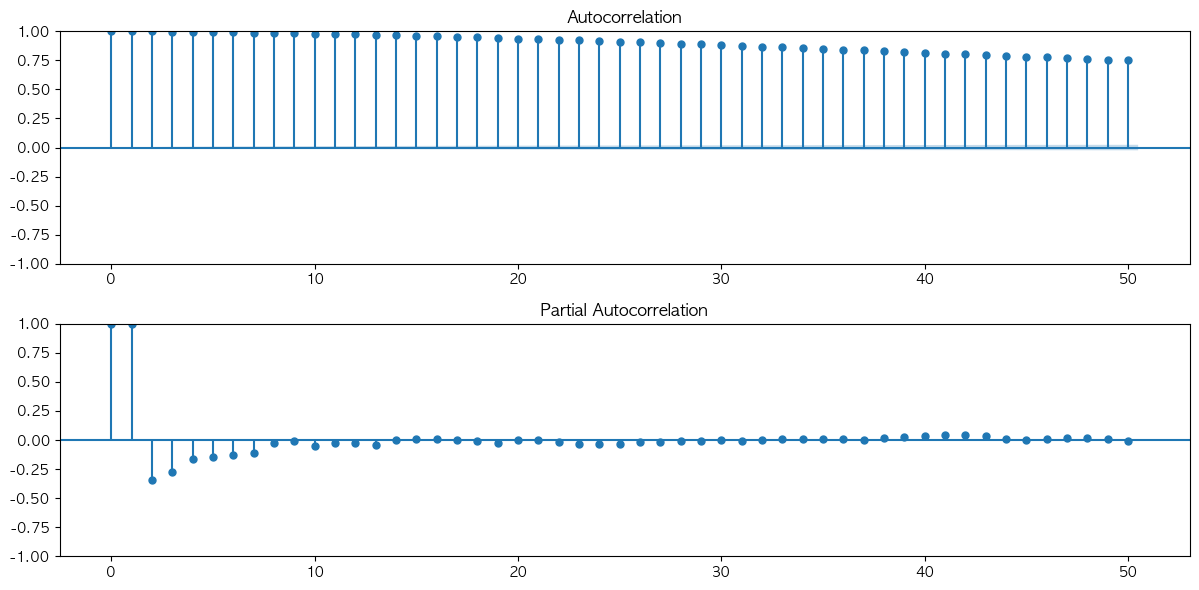

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 가정: `timeseries`는 분석하려는 시계열 데이터
timeseries = train_df.iloc[:, -1]

fig, ax = plt.subplots(2, figsize=(12,6))
plot_acf(timeseries, lags=50, ax=ax[0])
plot_pacf(timeseries, lags=50,  ax=ax[1])
plt.tight_layout()
plt.show()

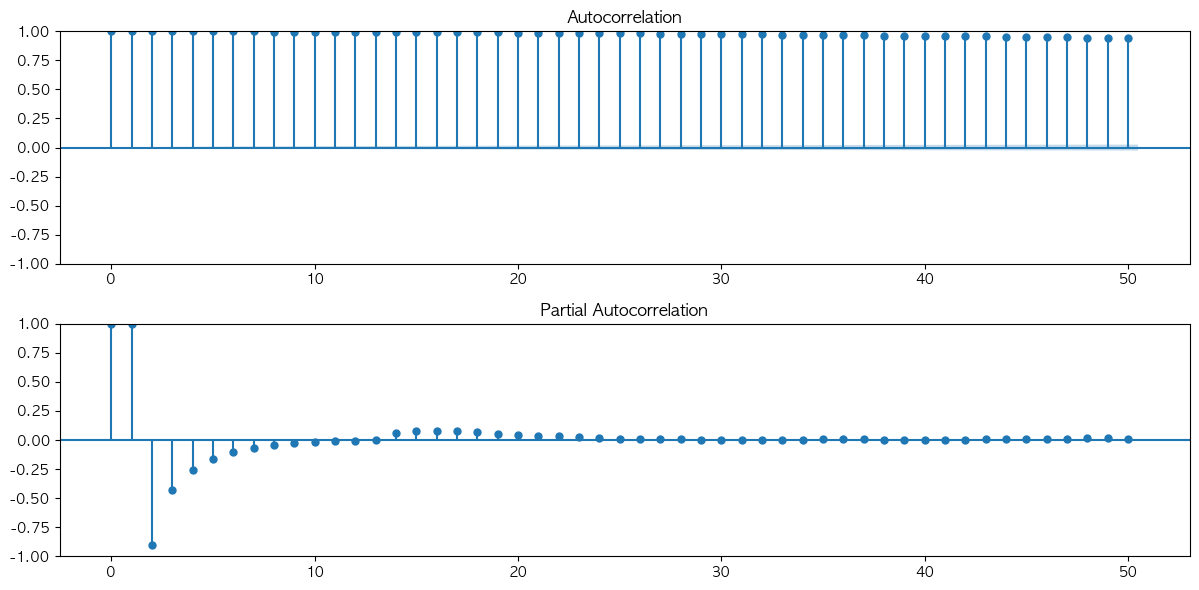

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 가정: `timeseries`는 분석하려는 시계열 데이터
timeseries = train_df['기온(°C)']

fig, ax = plt.subplots(2, figsize=(12,6))
plot_acf(timeseries, lags=50, ax=ax[0])
plot_pacf(timeseries, lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

### Encoded_data

In [42]:
X = encoded_train_df.drop(columns=['현재수요(MW)']).to_numpy()
y = encoded_train_df['현재수요(MW)'].to_numpy().reshape(-1, 1)

X_test = encoded_test_df.drop(columns=['현재수요(MW)']).to_numpy()
y_test = encoded_test_df['현재수요(MW)'].to_numpy().reshape(-1, 1)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state=20, shuffle=False)

In [44]:
X.shape, y.shape, X_test.shape, y_test.shape

((545505, 95), (545505, 1), (2016, 95), (2016, 1))

# DATA_Preprocessing

In [13]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

In [14]:
X.shape, y.shape, X_test.shape, y_test.shape

((546369, 10), (546369, 1), (1152, 10), (1152, 1))

In [15]:
#scailing

from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()


X_scaled = min_max_scaler.fit_transform(X.to_numpy())
X_test_scaled = min_max_scaler.fit_transform(X_test)

# DATA_preprocessing without scailing

In [48]:
X = train.iloc[:,:-1].to_numpy()
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=False)

# ARIMA

# ARIMAX

# VAR

# SARIMA